In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng = deu_eng[:50000,:]

In [6]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [7]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['who else is in there', 'wer ist noch dort drin',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3395974 (CK) & #3407455 (Pfirsichbaeumchen)'],
       ['who else was in here', 'wer war sonst noch hier drin',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3434402 (CK) & #3610264 (Jan_Schreiber)'],
       ['who fixed the window', 'wer hat das fenster hergerichtet',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9855581 (DJ_Saidez) & #9855585 (brauchinet)']],
      dtype='<U537')

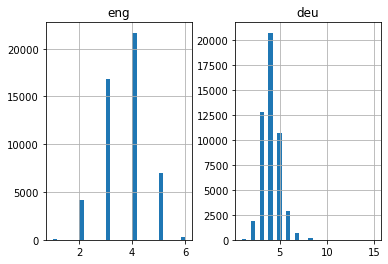

In [8]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [9]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6167


In [11]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10137


In [12]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [13]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [14]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [15]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [16]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [18]:
rms = 'adam'
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [19]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 26s 92ms/step - loss: 5.4954 - val_loss: 2.9819
Epoch 2/30
63/63 [==============================] - 4s 68ms/step - loss: 2.8638 - val_loss: 2.7981
Epoch 3/30
63/63 [==============================] - 4s 68ms/step - loss: 2.7274 - val_loss: 2.7378
Epoch 4/30
63/63 [==============================] - 4s 65ms/step - loss: 2.6488 - val_loss: 2.6967
Epoch 5/30
63/63 [==============================] - 4s 66ms/step - loss: 2.6044 - val_loss: 2.6655
Epoch 6/30
63/63 [==============================] - 4s 66ms/step - loss: 2.5437 - val_loss: 2.6165
Epoch 7/30
63/63 [==============================] - 4s 64ms/step - loss: 2.4876 - val_loss: 2.5675
Epoch 8/30
63/63 [==============================] - 4s 65ms/step - loss: 2.4286 - val_loss: 2.5148
Epoch 9/30
63/63 [==============================] - 4s 65ms/step - loss: 2.3445 - val_loss: 2.4403
Epoch 10/30
63/63 [==============================] - 4s 67ms/step - loss: 2.2526 - val_loss: 2.3500
Epoch 11

In [21]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\jesse\AppData\Roaming\Python\Python38\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


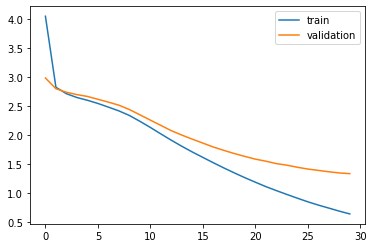

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [22]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [23]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [24]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [27]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
1484,it was too late,it was too
6416,we know you like tom,we know
9906,the sun is a star,the dog has
9499,is that car new,is this new
4402,dont talk like that,dont make to
5267,i couldnt stand,i couldnt stand
5007,this cake is sweet,this is sweet
9924,you seem upset,she seems upset
1564,i met tom in college,i never tom
9566,love will find a way,take the


In [35]:
preds[:50]

array([[  62,  379,    7,  118,    0,    0,    0,    0],
       [ 279,  625,    0,    0,    0,    0,    0,    0],
       [  75,  755,    0,    0,    0,    0,    0,    0],
       [ 102,   18,    0,    0,    0,    0,    0,    0],
       [  14,    4,   69,   83,    0,    0,    0,    0],
       [   1,  103,   10, 2285,    0,    0,    0,    0],
       [   9,  663,  681,    0,    0,    0,    0,    0],
       [  76,   18,    3,  116,  116,    0,    0,    0],
       [   2,   50,    5,  737,    0,    0,    0,    0],
       [1153,  197,  266,  266,    0,    0,    0,    0],
       [  39,   29,    8,    5,    0,    0,    0,    0],
       [   9,  598,    0,    0,    0,    0,    0,    0],
       [  20,  453,   46,    0,    0,    0,    0,    0],
       [ 132, 1472,    0,    0,    0,    0,    0,    0],
       [   1,    4,   30,    7,    0,    0,    0,    0],
       [  22,   22,  444,    0,    0,    0,    0,    0],
       [   1,   41,    5,    0,    0,    0,    0,    0],
       [   1,  351,  259,    0,

In [29]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.
